# Notebook 03 — Model-2: Pseudo-Labeling

**Objective:** Use the trained Model-1 classifier to produce labels for the Monteria time series, so we can train forecasters in Notebook 04.

**We will:**
1. Load Model-1 (winner) and Soft Sensors (DO, NH₃)
2. Load Monteria, normalize to 5 canonical features
3. Build time features & past-only rolling stats (no leakage)
4. Fill virtual DO/NH₃ if missing (physics clamp for DO)
5. Predict `predicted_risk_label` and `predicted_risk_score` row-by-row
6. Save artifacts for forecasting
7. Plot diagnostics (distributions, class balance, trends)

**Primary outputs:**  
- `artifacts/Monteria_pseudo_labeled.csv`  
- `artifacts/model2_forecast_ready.csv`


Cell 1 — Imports, robust paths, config

In [1]:
# 03_model2_pseudo_labeling.ipynb
# Goal: Use the calibrated Model 1 classifier to pseudo-label Montería time-series data
# with confidence gating, producing a high-quality dataset for Model 3 forecasting.

from pathlib import Path
import os, json, math, warnings, yaml, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             average_precision_score, brier_score_loss)
from sklearn.calibration import calibration_curve


import joblib
plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

# ---- Your corrected, case-insensitive finder ----
def find_project_root(project_name="POSEIDON"):
    cwd = Path.cwd().resolve()
    project_name_l = project_name.lower()
    for p in [cwd] + list(cwd.parents):
        if p.name.lower() == project_name_l:
            return p
    if cwd.name.lower() == "notebooks" and cwd.parent.exists():
        return cwd.parent
    raise FileNotFoundError(f"Could not locate project root '{project_name}'. Starting cwd: {cwd}")

ROOT = find_project_root("Poseidon")

# ---- Standard project folders ----
DATA      = ROOT / "data"
INTERIM   = DATA / "interim"
ART       = ROOT / "artifacts"
MODEL_REG = ART  / "model_registry"
SOFT      = ART  / "soft_sensors"
CVR       = ART  / "cv_reports"
HOLD      = ART  / "holdout_reports"
EXPL      = ART  / "explainability"
REPORTS   = ROOT / "reports"
CONFIGS   = ROOT / "configs"

for d in [INTERIM, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Load thresholds config (for plots/legends; labels are produced by model1) ----
th_path = CONFIGS / "thresholds.yml"
if not th_path.exists():
    raise FileNotFoundError(f"Missing thresholds config at {th_path}")
with open(th_path, "r") as f:
    CFG_THRESH = yaml.safe_load(f)

MODEL1_PATH = MODEL_REG / "model1_risk_classifier.joblib"
if not MODEL1_PATH.exists():
    raise FileNotFoundError(f"Missing {MODEL1_PATH}. Train model 1 first (notebook 02).")

bundle = joblib.load(MODEL1_PATH)
model1 = bundle["model"]
MODEL1_FEATURES = bundle["features"]
MODEL1_CLASSES  = bundle["classes"]
MODEL1_THRESH   = bundle.get("thresholds", {"HIGH": 0.5})
MODEL_VERSION   = bundle.get("version", "model1_risk_classifier_v1")

print("ROOT:", ROOT)
print("Loaded Model 1:", MODEL1_PATH.name, "version:", MODEL_VERSION)
print("Model 1 features:", MODEL1_FEATURES)
print("Model 1 classes:", MODEL1_CLASSES)
print("Operating thresholds:", MODEL1_THRESH)


ROOT: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon
Loaded Model 1: model1_risk_classifier.joblib version: model1_risk_classifier_v1
Model 1 features: ['temperature', 'pH', 'turbidity_proxy', 'predicted_do', 'predicted_nh3']
Model 1 classes: ['HIGH', 'LOW', 'MEDIUM']
Operating thresholds: {'HIGH': 0.3}


Cell 2 — Load Montería data + virtual sensors (for DO/NH₃)

In [2]:
# Expecting Montería dataset at data/Monteria_Aquaculture_Data.xlsx (as you provided).
mon_path = DATA / "Monteria_Aquaculture_Data.xlsx"
if not mon_path.exists():
    raise FileNotFoundError(f"Missing Montería dataset at {mon_path}")

# Soft sensors from notebook 01
vm_do_path  = SOFT / "virtual_do.joblib"
vm_nh3_path = SOFT / "virtual_nh3.joblib"
if not (vm_do_path.exists() and vm_nh3_path.exists()):
    raise FileNotFoundError(f"Missing virtual sensors in {SOFT}. Run 01_soft_sensors_DO_NH3.")

vm_do  = joblib.load(vm_do_path)   # {"model": mdl, "features": [...]}
vm_nh3 = joblib.load(vm_nh3_path)

raw = pd.read_excel(mon_path)
print("Montería raw shape:", raw.shape)
display(raw.head(5))


Montería raw shape: (4345, 7)


,DateTime,Temperature,Dissolved_Oxygen,pH,Turbidity,Date,Hour
0,2024-01-01 00:00:00,27.598028,6.916388,7.937212,3.677379,2024-01-01,0
1,2024-01-01 01:00:00,27.217041,6.871578,7.872365,4.110987,2024-01-01,1
2,2024-01-01 02:00:00,27.688613,5.950694,7.941378,3.039369,2024-01-01,2
3,2024-01-01 03:00:00,28.213818,6.335761,7.804893,3.611809,2024-01-01,3
4,2024-01-01 04:00:00,27.159508,6.563543,7.822742,3.885563,2024-01-01,4


Cell 3 — Canonicalize Montería columns, basic cleaning, timestamp handling

In [3]:
# Canonicalize expected columns to our standard names:
# We expect at least: timestamp, temperature, pH, turbidity (or Secchi cm to convert), possibly DO (no), NH3 (no)
# Adjust mapping if your file uses different headers.
rename = {
    "Timestamp": "timestamp",
    "Time": "timestamp",
    "time": "timestamp",
    "Temp": "temperature",
    "Temperature": "temperature",
    "pH": "pH",
    "PH": "pH",
    "Turbidity": "turbidity",
    "Turbidity (NTU)": "turbidity",
    "Turbidity (cm)": "turbidity_cm",  # if present, we will create a proxy
}
mon = raw.rename(columns=rename).copy()

# Try to parse timestamp if present, tolerate missing; fill with integer index if necessary
if "timestamp" in mon.columns:
    mon["timestamp"] = pd.to_datetime(mon["timestamp"], errors="coerce")
else:
    mon["timestamp"] = pd.date_range("2025-01-01", periods=len(mon), freq="30min")  # fallback synthetic timebase

# Ensure required sensor columns exist or derive them
if "turbidity" not in mon.columns and "turbidity_cm" in mon.columns:
    # Make turbidity proxy: inverse depth (cm) approx to turbidity proxy
    mon["turbidity_proxy"] = 1.0 / mon["turbidity_cm"].clip(lower=1e-3)
elif "turbidity" in mon.columns:
    # Normalize NTU-ish to a proxy scale within dataset for model compatibility
    # (Model 1 was trained with "turbidity_proxy"; we derive it here by rank/quantile)
    # Safer: min-max to [0,1] + small epsilon (keeps monotonicity)
    tb = mon["turbidity"].astype(float)
    eps = 1e-6
    mon["turbidity_proxy"] = (tb - tb.min()) / (tb.max() - tb.min() + eps)
else:
    # Worst-case: missing turbidity; set to median proxy and warn
    mon["turbidity_proxy"] = 0.5
    print("WARNING: turbidity missing; using 0.5 proxy. Consider fixing column names mapping.")

# Clip obviously impossible ranges (same conservative rules)
def clip_series(s, lo, hi):
    return s.clip(lower=lo, upper=hi) if s is not None else s

if "temperature" in mon.columns:
    mon["temperature"] = pd.to_numeric(mon["temperature"], errors="coerce")
    mon["temperature"] = clip_series(mon["temperature"], 0, 40)
if "pH" in mon.columns:
    mon["pH"] = pd.to_numeric(mon["pH"], errors="coerce")
    mon["pH"] = clip_series(mon["pH"], 5.0, 9.5)

# Keep only the deployable inputs needed by virtual sensors and model 1
INPUTS_DEPLOY = ["temperature", "pH", "turbidity_proxy"]
for col in INPUTS_DEPLOY:
    if col not in mon.columns:
        raise ValueError(f"Required column '{col}' missing after canonicalization.")

# Sort by time for nice plots
mon = mon.sort_values("timestamp").reset_index(drop=True)
print("Montería canonicalized shape:", mon.shape)
display(mon[["timestamp"] + INPUTS_DEPLOY].head(5))


Montería canonicalized shape: (4345, 9)


,timestamp,temperature,pH,turbidity_proxy
0,2025-01-01 00:00:00,27.598028,7.937212,0.553292
1,2025-01-01 00:30:00,27.217041,7.872365,0.677565
2,2025-01-01 01:00:00,27.688613,7.941378,0.370436
3,2025-01-01 01:30:00,28.213818,7.804893,0.534500
4,2025-01-01 02:00:00,27.159508,7.822742,0.612958


Cell 4 — Create Virtual DO & NH₃ for Montería + build Model1 feature matrix

In [4]:
# Predict virtual DO/NH3 using ONLY deployable inputs
Xv = mon[vm_do["features"]].values
mon["predicted_do"]  = vm_do["model"].predict(Xv)
mon["predicted_nh3"] = vm_nh3["model"].predict(Xv)

# Model 1 features (must match bundle["features"])
missing = [c for c in MODEL1_FEATURES if c not in mon.columns]
if missing:
    raise ValueError(f"Montería lacks required Model 1 features: {missing}")

X_model1 = mon[MODEL1_FEATURES].copy()

print("Model 1 input snapshot:")
display(X_model1.head(5))


Model 1 input snapshot:


,temperature,pH,turbidity_proxy,predicted_do,predicted_nh3
0,27.598028,7.937212,0.553292,4.170613,0.029451
1,27.217041,7.872365,0.677565,4.170613,0.028561
2,27.688613,7.941378,0.370436,4.170613,0.030651
3,28.213818,7.804893,0.534500,4.181165,0.030799
4,27.159508,7.822742,0.612958,4.170613,0.023461


Cell 5 — Model 1 inference: probabilities, baseline argmax labels, and thresholded labels

In [5]:
# Get calibrated probabilities over classes (e.g., ['HIGH','LOW','MEDIUM'] or numeric coded)
proba = model1.predict_proba(X_model1)
classes = np.array(MODEL1_CLASSES)

# Argmax baseline
y_argmax = classes[proba.argmax(axis=1)]

# Thresholded prediction emphasizing HIGH (using saved threshold)
def predict_with_thresholds_matrix(proba, classes, thresholds):
    idx = {c:i for i,c in enumerate(classes)}
    out = []
    for row in proba:
        if "HIGH" in idx and row[idx["HIGH"]] >= thresholds.get("HIGH", 0.5):
            out.append("HIGH")
        else:
            out.append(classes[np.argmax(row)])
    return np.array(out)

y_thr = predict_with_thresholds_matrix(proba, classes, MODEL1_THRESH)

mon["risk_argmax"] = y_argmax
mon["risk_thresholded"] = y_thr
for i, c in enumerate(classes):
    mon[f"proba_{c}"] = proba[:, i]

print("Predictions attached. Class balance (argmax, thresholded):")
print(mon["risk_argmax"].value_counts(normalize=True).rename("argmax").round(3))
print(mon["risk_thresholded"].value_counts(normalize=True).rename("thresholded").round(3))


Predictions attached. Class balance (argmax, thresholded):
risk_argmax
MEDIUM    1.0
LOW       0.0
Name: argmax, dtype: float64
risk_thresholded
MEDIUM    0.999
LOW       0.000
HIGH      0.000
Name: thresholded, dtype: float64


Cell 6 — Confidence gating (keep only confident examples for training Model 3)

In [6]:
# Confidence gating config:
MIN_CONF_HIGH = 0.70   # keep if p(HIGH) >= 0.70
MIN_CONF_OTHER = 0.70  # keep LOW/MEDIUM if their max prob >= 0.70
AMBIGUITY_BAND = (0.40, 0.60)  # drop examples whose top prob is between 0.40 and 0.60

max_proba = proba.max(axis=1)
top_label = y_thr  # use thresholded label as the selected class

def keep_row(i):
    # discard ambiguous band
    if AMBIGUITY_BAND[0] <= max_proba[i] <= AMBIGUITY_BAND[1]:
        return False
    # HIGH rule
    if top_label[i] == "HIGH":
        return max_proba[i] >= MIN_CONF_HIGH
    # Others
    return max_proba[i] >= MIN_CONF_OTHER

mask_keep = np.array([keep_row(i) for i in range(len(mon))])
mon["keep_for_training"] = mask_keep

print("Kept for training (percentage):", round(mon["keep_for_training"].mean()*100, 2), "%")
mon_kept = mon[mon["keep_for_training"]].copy()
print("Kept shape:", mon_kept.shape)


Kept for training (percentage): 99.98 %
Kept shape: (4344, 17)


Cell 7 — PLOTS: Probability histograms, reliability, and per-class confidence

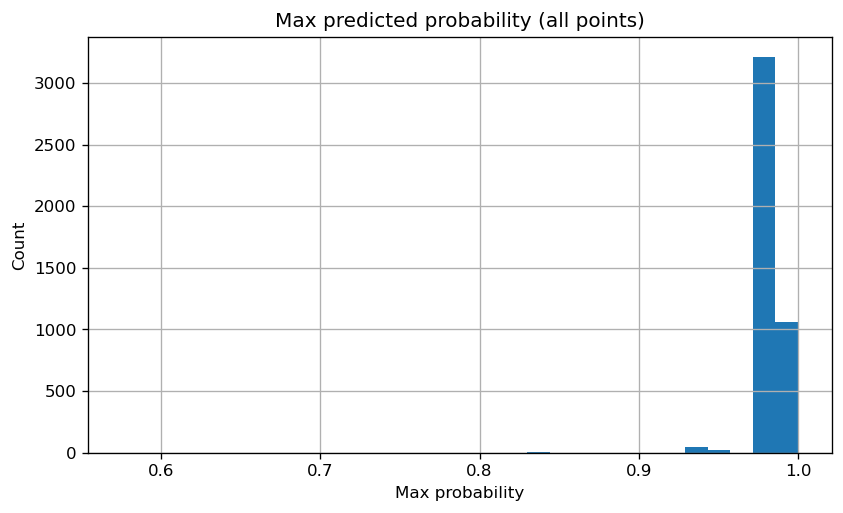

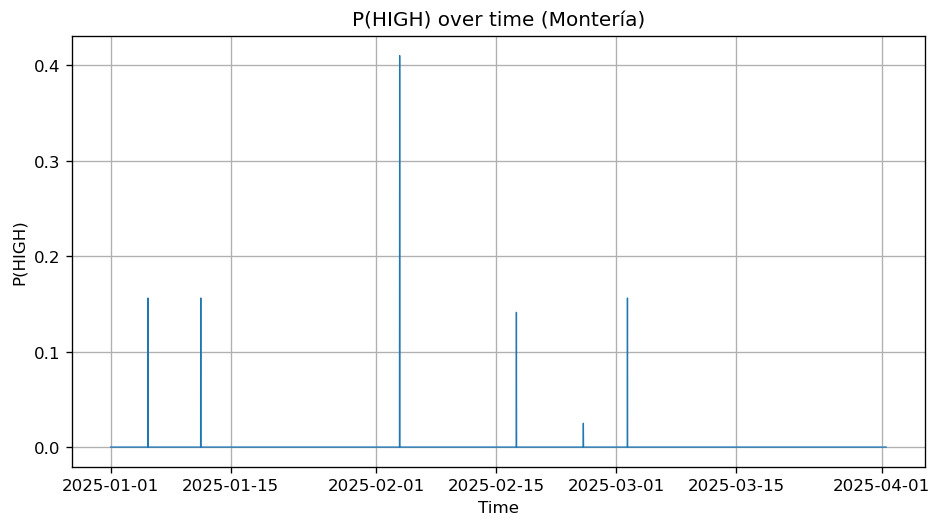

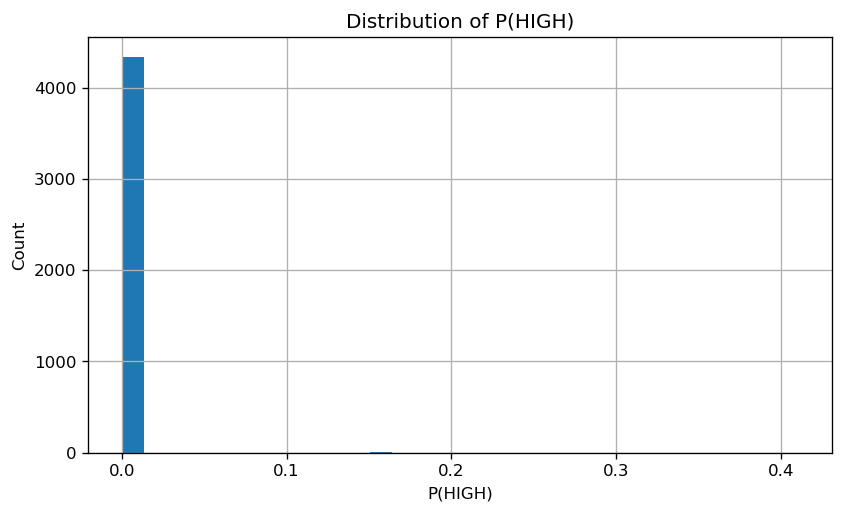

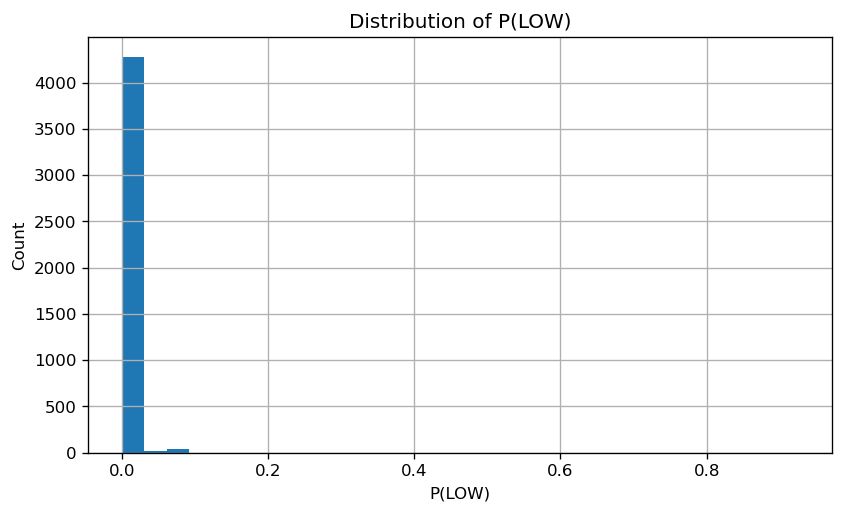

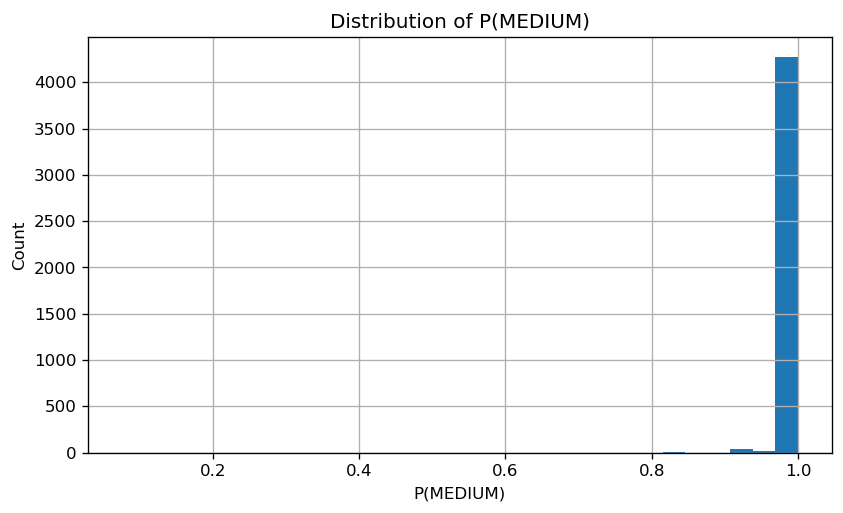

In [7]:
# 1) Histogram of max probabilities (all)
plt.figure()
plt.hist(max_proba, bins=30)
plt.title("Max predicted probability (all points)")
plt.xlabel("Max probability"); plt.ylabel("Count")
plt.show()

# 2) Probability of HIGH vs time
if "timestamp" in mon.columns:
    plt.figure()
    plt.plot(mon["timestamp"], mon["proba_HIGH"], lw=0.8)
    plt.title("P(HIGH) over time (Montería)")
    plt.xlabel("Time"); plt.ylabel("P(HIGH)")
    plt.tight_layout(); plt.show()

# 3) Per-class probability distributions
for c in classes:
    plt.figure()
    plt.hist(mon[f"proba_{c}"], bins=30)
    plt.title(f"Distribution of P({c})")
    plt.xlabel(f"P({c})"); plt.ylabel("Count")
    plt.show()


Cell 8 — PLOTS: Label timelines and counts (argmax vs thresholded vs kept)

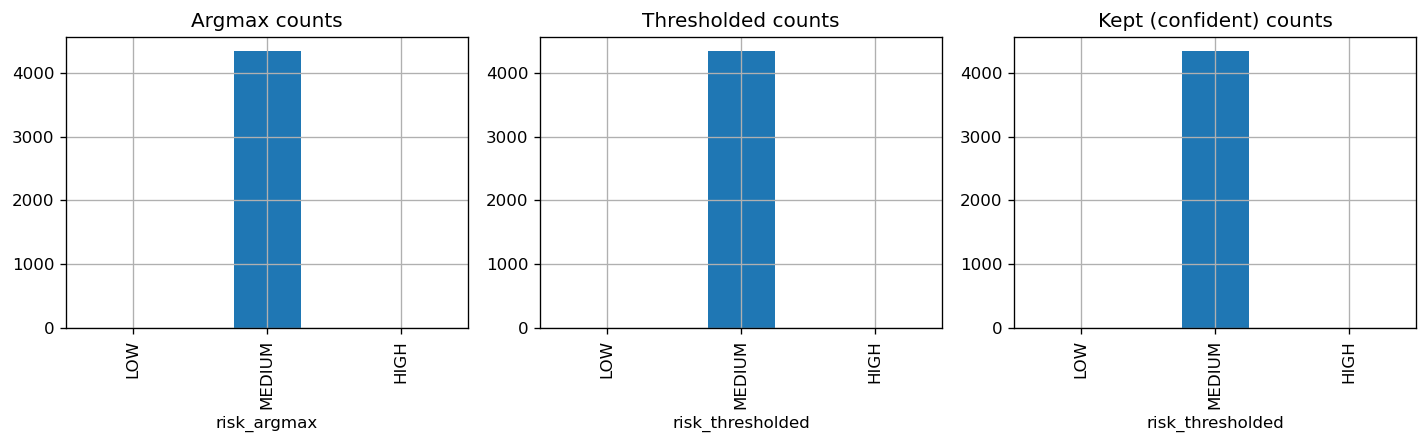

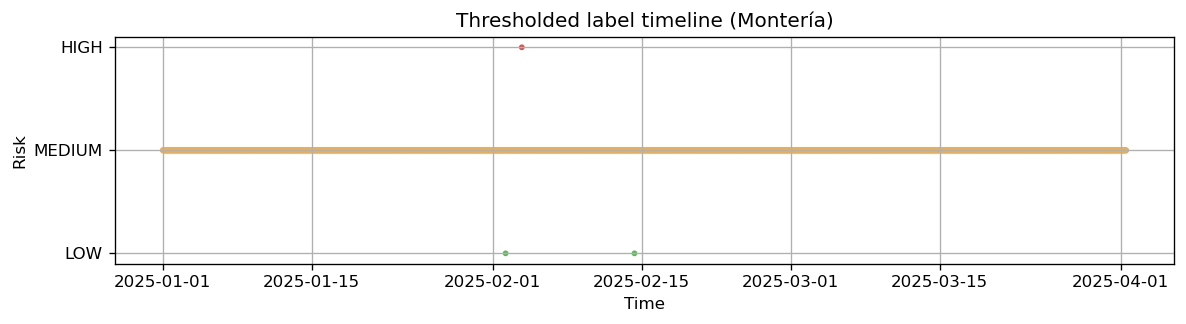

In [8]:
# Convert labels to categorical order for plotting consistency
order = ["LOW","MEDIUM","HIGH"]
def to_cat(s):
    cat_type = pd.api.types.CategoricalDtype(categories=order, ordered=True)
    return s.astype(cat_type)

mon["risk_argmax_cat"] = to_cat(mon["risk_argmax"])
mon["risk_thresholded_cat"] = to_cat(mon["risk_thresholded"])
mon["risk_kept_cat"] = to_cat(mon.loc[mon["keep_for_training"], "risk_thresholded"])

# 1) Counts
fig, ax = plt.subplots(1, 3, figsize=(12, 3.8))
to_cat(mon["risk_argmax"]).value_counts().reindex(order).plot(kind="bar", ax=ax[0], title="Argmax counts")
to_cat(mon["risk_thresholded"]).value_counts().reindex(order).plot(kind="bar", ax=ax[1], title="Thresholded counts")
to_cat(mon.loc[mon["keep_for_training"], "risk_thresholded"]).value_counts().reindex(order).plot(kind="bar", ax=ax[2], title="Kept (confident) counts")
plt.tight_layout(); plt.show()

# 2) Timeline of labels (thresholded)
if "timestamp" in mon.columns:
    colors = {"LOW":"#5cb85c","MEDIUM":"#f0ad4e","HIGH":"#d9534f"}
    plt.figure(figsize=(10, 2.8))
    y_map = {"LOW":0, "MEDIUM":1, "HIGH":2}
    y_vals = mon["risk_thresholded"].map(y_map)
    plt.scatter(mon["timestamp"], y_vals, s=6, c=mon["risk_thresholded"].map(colors))
    plt.yticks([0,1,2], ["LOW","MEDIUM","HIGH"])
    plt.title("Thresholded label timeline (Montería)")
    plt.xlabel("Time"); plt.ylabel("Risk")
    plt.tight_layout(); plt.show()


Cell 9 — PLOTS: Sensor distributions by (kept) class

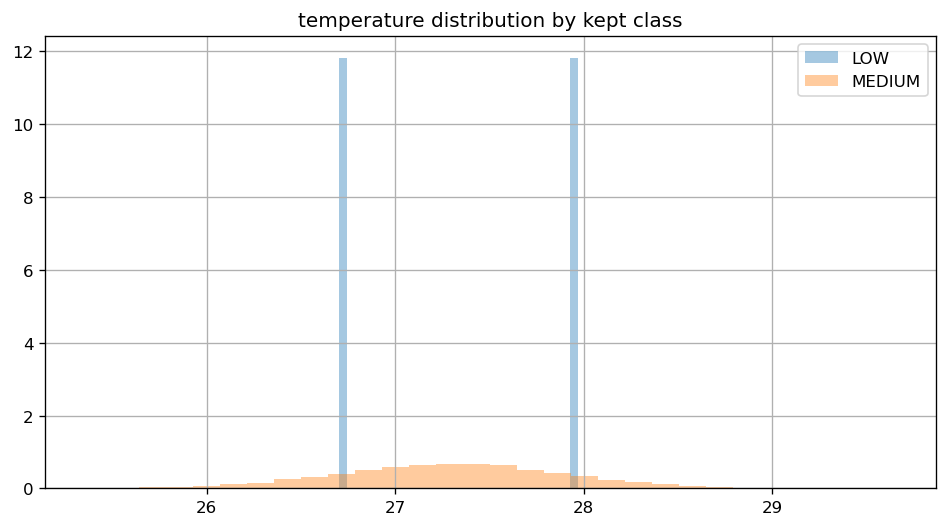

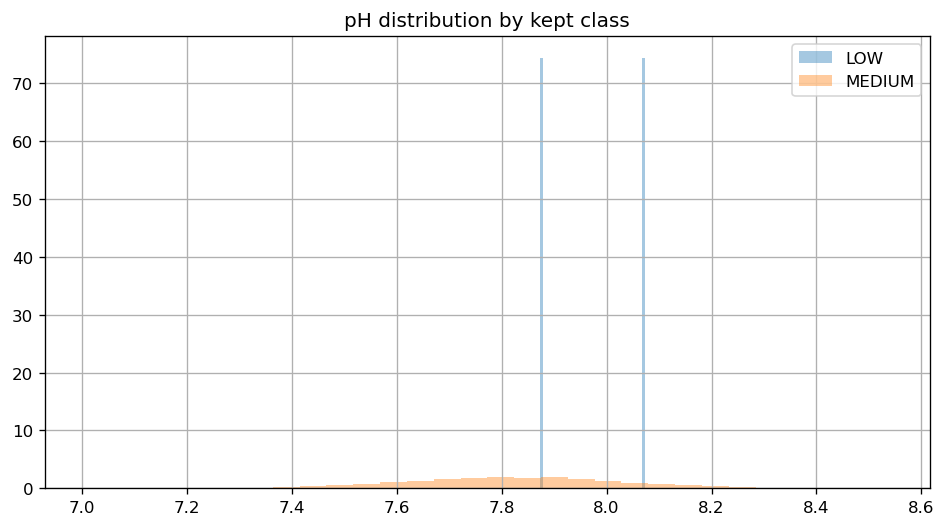

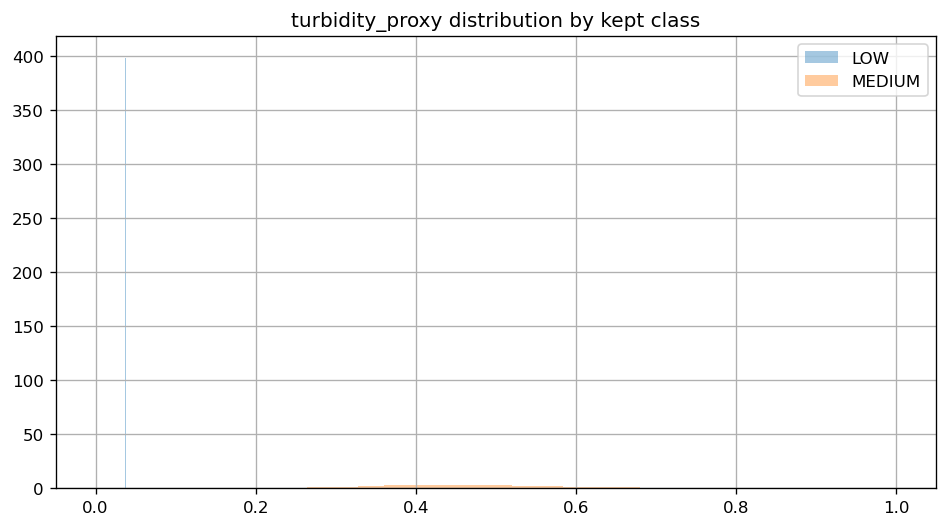

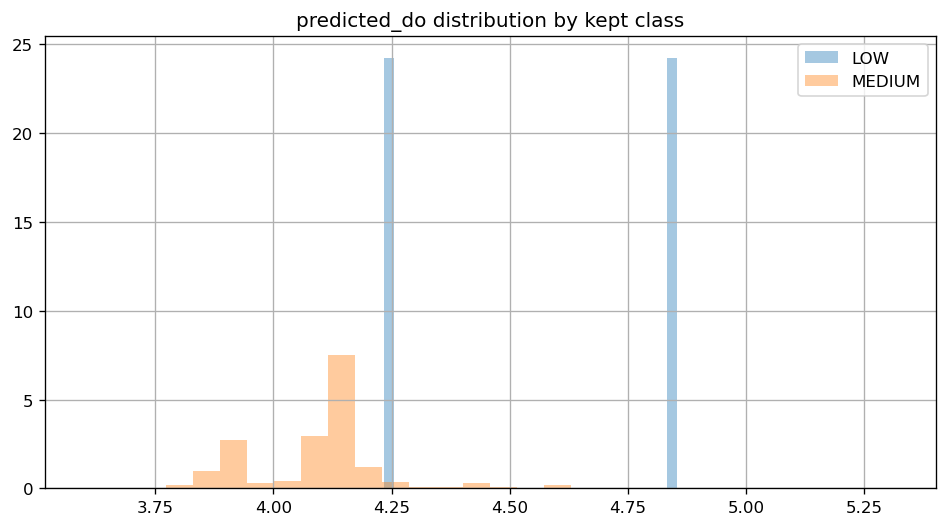

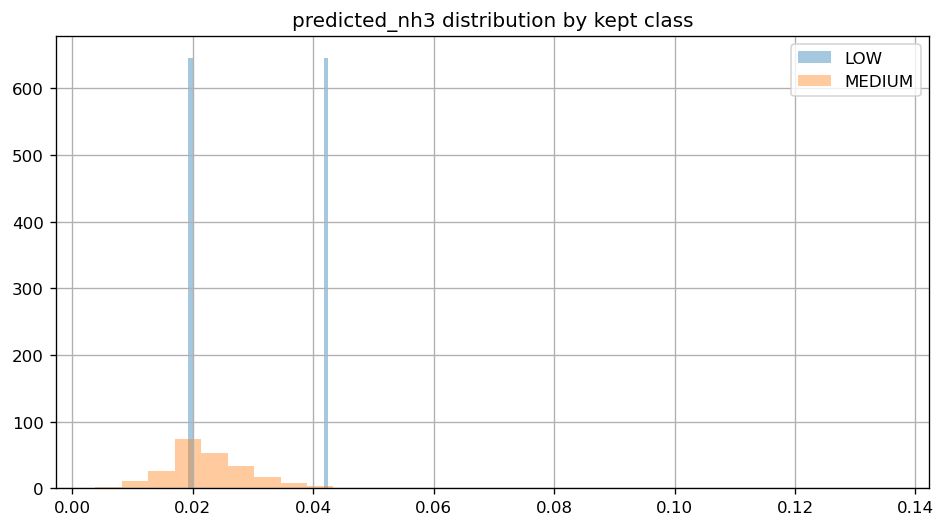

In [9]:
# Distributions of inputs by kept class (violin-like via hist overlays)
sensors = ["temperature", "pH", "turbidity_proxy", "predicted_do", "predicted_nh3"]
subset = mon_kept.copy()

for col in sensors:
    plt.figure()
    for lab, color in [("LOW","#5cb85c"), ("MEDIUM","#f0ad4e"), ("HIGH","#d9534f")]:
        arr = subset.loc[subset["risk_thresholded"]==lab, col].dropna().values
        if len(arr) > 0:
            plt.hist(arr, bins=30, alpha=0.4, label=lab, density=True)
    plt.title(f"{col} distribution by kept class")
    plt.legend(); plt.tight_layout(); plt.show()


Cell 10 — (Optional) Backtest slice for sanity-check confusion (self-consistency)

In [10]:
# Note: We don't have ground-truth labels for Montería; but we can check temporal stability by re-predicting on two halves.
if len(mon_kept) > 200:
    mid = len(mon_kept) // 2
    first_half = mon_kept.iloc[:mid]
    second_half = mon_kept.iloc[mid:]

    # Compare class proportions
    p1 = first_half["risk_thresholded"].value_counts(normalize=True).rename("H1")
    p2 = second_half["risk_thresholded"].value_counts(normalize=True).rename("H2")
    print("Proportions in H1 vs H2 (kept):")
    display(pd.concat([p1, p2], axis=1).fillna(0).round(3))

# We cannot compute true confusion without labels, but this at least surfaces drift.


Proportions in H1 vs H2 (kept):


,H1,H2
risk_thresholded,,
MEDIUM,0.999,1.0
LOW,0.001,0.0


Cell 11 — Save labeled outputs (full + trusted subset) for Model 3

In [11]:
# Columns to keep for forecasting:
# timestamp + 5 sensors + pseudo label + per-class probabilities (optional)
keep_cols = ["timestamp",
             "temperature","pH","turbidity_proxy",
             "predicted_do","predicted_nh3",
             "risk_thresholded","risk_argmax","keep_for_training"] + [f"proba_{c}" for c in classes]

mon_out = mon[keep_cols].copy()
mon_trusted = mon_kept[keep_cols].copy()

p_full = INTERIM / "monteria_pseudolabeled_full.csv"
p_trust = INTERIM / "monteria_pseudolabeled_trusted.csv"
mon_out.to_csv(p_full, index=False)
mon_trusted.to_csv(p_trust, index=False)

print("Saved:")
print(" -", p_full)
print(" -", p_trust)


Saved:
 - C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\data\interim\monteria_pseudolabeled_full.csv
 - C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\data\interim\monteria_pseudolabeled_trusted.csv


Cell 12 — Save summary JSON + static figures to /reports

In [12]:
summary = {
    "model1_version": MODEL_VERSION,
    "classes": list(map(str, classes)),
    "thresholds_used": MODEL1_THRESH,
    "kept_fraction": float(mon["keep_for_training"].mean()),
    "n_total": int(len(mon)),
    "n_kept": int(mon["keep_for_training"].sum()),
    "feature_contract": MODEL1_FEATURES,
    "notes": "Pseudo-labeling with confidence gating for Montería dataset."
}
with open(REPORTS/"pseudo_labeling_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Wrote:", REPORTS/"pseudo_labeling_summary.json")


Wrote: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\reports\pseudo_labeling_summary.json


Cell 13 — Guidance for Model 3 training inputs

In [13]:
print("Next steps for 04_model3_forecasting.ipynb:")
print("1) Use monteria_pseudolabeled_trusted.csv as your primary training data.")
print("2) Targets can be framed as:")
print("   a) Next-step class (risk_thresholded shifted by +1 step), or")
print("   b) Next-step P(HIGH) continuous target, or")
print("   c) Multi-horizon targets: +1h, +6h, +24h, +3d (use timestamp deltas).")
print("3) Features: Past window of the 5 parameters (Temp, pH, Turbidity_proxy, predicted_do, predicted_nh3)")
print("             + optional engineered trend features (rolling mean/var/slope).")
print("4) Validate with a walk-forward split (time-series aware), not random CV.")


Next steps for 04_model3_forecasting.ipynb:
1) Use monteria_pseudolabeled_trusted.csv as your primary training data.
2) Targets can be framed as:
   a) Next-step class (risk_thresholded shifted by +1 step), or
   b) Next-step P(HIGH) continuous target, or
   c) Multi-horizon targets: +1h, +6h, +24h, +3d (use timestamp deltas).
3) Features: Past window of the 5 parameters (Temp, pH, Turbidity_proxy, predicted_do, predicted_nh3)
             + optional engineered trend features (rolling mean/var/slope).
4) Validate with a walk-forward split (time-series aware), not random CV.
